In [22]:
import pandas as pd
from transformers import AutoTokenizer,AutoModelForSequenceClassification,Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('Khilnani_LP_spam_detection_data.csv',index_col=0)

In [4]:
import nltk
import re
nltk.download("stopwords")
def clean_text(text):
  stopwords = nltk.corpus.stopwords.words('english')
  text = text.lower() # Convert to lower case
  text = re.sub(r'[^\w\s]', '', text) # Remove everything except words
  words = [word for word in text.split() if word not in stopwords] # Remove stopwords
  text = " ".join(words)
  return text

[nltk_data] Downloading package stopwords to /home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df['SMS'] = df['SMS'].apply(clean_text)

In [6]:
def label_name(label):
    return 'Spam' if label == 1 else 'Not Spam'

In [7]:
df['label_name'] = df['label'].apply(label_name)

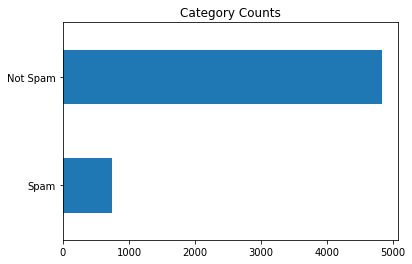

In [8]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Category Counts");

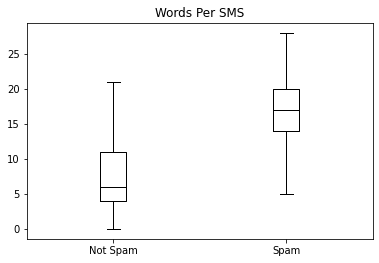

In [9]:
df["Words Per SMS"] = df["SMS"].str.split().apply(len)
df.boxplot("Words Per SMS", by='label_name', grid=False, showfliers=False,
           color='black', )
plt.suptitle("")
plt.xlabel("");

In [10]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
x = df["SMS"].values
y = df["label"].values

# Split into training and validation sets

train_data, val_data, train_labels, val_labels = train_test_split(x, y)

In [12]:
train_tokens = tokenizer(list(train_data), return_tensors="pt", padding=True, truncation=True, max_length=64)
val_tokens = tokenizer(list(val_data), return_tensors="pt", padding=True, truncation=True, max_length=64)

In [13]:
class SMSDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [14]:
train_dataset = SMSDataset(train_tokens, list(train_labels))
val_dataset = SMSDataset(val_tokens, list(val_labels))

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

In [16]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [17]:
batch_size = 64
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy = "epoch",
                                  disable_tqdm=False,
                                  logging_steps=64)

In [18]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset)
trainer.train();

***** Running training *****
  Num examples = 4180
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 132
/tmp/ipykernel_467/2453827660.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.193700,0.063132,0.982783,0.982664
2,0.041700,0.055004,0.985653,0.985620


***** Running Evaluation *****
  Num examples = 1394
  Batch size = 64
Saving model checkpoint to results/checkpoint-66
Configuration saved in results/checkpoint-66/config.json
Model weights saved in results/checkpoint-66/pytorch_model.bin
/tmp/ipykernel_467/2453827660.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1394
  Batch size = 64
Saving model checkpoint to results/checkpoint-132
Configuration saved in results/checkpoint-132/config.json
Model weights saved in results/checkpoint-132/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/checkpoint-132 (score: 0.9856199549817359).


In [19]:
results = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1394
  Batch size = 64
/tmp/ipykernel_467/2453827660.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [20]:
preds_output = trainer.predict(val_dataset)

***** Running Prediction *****
  Num examples = 1394
  Batch size = 64
/tmp/ipykernel_467/2453827660.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [21]:
preds_output.metrics

{'test_loss': 0.05500366538763046,
 'test_accuracy': 0.9856527977044476,
 'test_f1': 0.9856199549817359,
 'test_runtime': 1.1298,
 'test_samples_per_second': 1233.823,
 'test_steps_per_second': 19.472}

In [23]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [24]:
from sklearn.metrics import classification_report,plot_confusion_matrix

In [25]:
print(classification_report(val_labels, y_preds, target_names=['Not Spam','SPAM']))

              precision    recall  f1-score   support

    Not Spam       0.99      0.99      0.99      1208
        SPAM       0.95      0.94      0.95       186

    accuracy                           0.99      1394
   macro avg       0.97      0.97      0.97      1394
weighted avg       0.99      0.99      0.99      1394



In [26]:
custom_sms = "YOUR WHATS-APP NO HAVE BEEN AWARDED 500,000USD IN IPHONE & WHATS-APP COMPANY PROMO.TO CLAIM SEND UR NAME ADDS AGE MOBILE"
custom_sms = clean_text(custom_sms)
input_tensor = tokenizer.encode(custom_sms, return_tensors="pt").to("cuda")
logits = model(input_tensor).logits

In [27]:
logits

tensor([[-1.5867,  1.2464]], device='cuda:0', grad_fn=<AddmmBackward>)

In [28]:
softmax = torch.nn.Softmax(dim=1)
probs = softmax(logits)[0]
probs = probs.cpu().detach().numpy()

In [29]:
probs

array([0.05556234, 0.9444377 ], dtype=float32)

In [30]:
trainer.save_model("models/distilbert-sms_spam")
tokenizer.save_pretrained("models/sms_spam")

Saving model checkpoint to models/distilbert-sms_spam
Configuration saved in models/distilbert-sms_spam/config.json
Model weights saved in models/distilbert-sms_spam/pytorch_model.bin
tokenizer config file saved in models/sms_spam/tokenizer_config.json
Special tokens file saved in models/sms_spam/special_tokens_map.json


('models/sms_spam/tokenizer_config.json',
 'models/sms_spam/special_tokens_map.json',
 'models/sms_spam/vocab.txt',
 'models/sms_spam/added_tokens.json',
 'models/sms_spam/tokenizer.json')